In [1]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import torch
import torch.nn as nn
import torchvision
from torchsummary import summary

In [ ]:
current_dir = os.getcwd()

def check_exists_path(path):
    if not os.path.exists(path):
        os.makedirs(f"{current_dir}/{path}")

# Обучение Language Identification модели

In [ ]:
def load_dataset(split: str = "train"):
    data_path = f"data/{split}_spectrogram"
    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=torchvision.transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=0, shuffle=True)
    return loader, dataset

train_loader, _ = load_dataset(split="train")
valid_loader, valid_dataset = load_dataset(split="valid")
test_loader, test_dataset = load_dataset(split="test")

In [2]:
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.fc1 = nn.Linear(18432, 1000)
        self.fc2 = nn.Linear(1000, 3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 100, 100]           2,432
       BatchNorm2d-2         [-1, 32, 100, 100]              64
              ReLU-3         [-1, 32, 100, 100]               0
         MaxPool2d-4           [-1, 32, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          51,264
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
         MaxPool2d-8           [-1, 64, 25, 25]               0
            Conv2d-9          [-1, 128, 25, 25]         204,928
      BatchNorm2d-10          [-1, 128, 25, 25]             256
             ReLU-11          [-1, 128, 25, 25]               0
        MaxPool2d-12          [-1, 128, 12, 12]               0
           Linear-13                 [-1, 1000]      18,433,000
           Linear-14                   

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs_count = 30
count_batches = len(train_loader)

train_loss_step_history = []
train_accuracy_step_history = []

train_loss_epoch_history = []
train_accuracy_epoch_history = []

valid_loss_epoch_history = []
valid_accuracy_epoch_history = []

In [ ]:
for epoch in range(0, epochs_count):
    correct_train, total_train, error_train = 0, 0, 0
    for idx, (images_train, labels_train) in enumerate(train_loader):

        outputs_train = model(images_train)
        error_train = loss(outputs_train, labels_train)
        train_loss_step_history.append(error_train.item())

        optimizer.zero_grad()
        error_train.backward()
        optimizer.step()

        total_train = labels_train.size(0)
        _, predicted_train = torch.max(outputs_train.data, 1)
        correct_train = (predicted_train == labels_train).sum().item()
        train_accuracy_step_history.append(correct_train / total_train * 100)

        correct_train += correct_train
        error_train += error_train
        total_train += total_train

        clear_output()
        display('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
            epoch + 1,
            epochs_count,
            idx + 1,
            count_batches,
            error_train.item(),
            train_accuracy_step_history[-1],
        ))


    correct_valid, total_valid, error_valid = 0, 0, 0
    for idx, (images_valid, labels_valid) in enumerate(test_loader):

        outputs_valid = model(images_valid)
        error_valid = loss(outputs_valid, labels_valid)

        total_valid += labels_valid.size(0)
        _, predicted_valid = torch.max(outputs_valid.data, 1)
        correct_valid += (predicted_valid == labels_valid).sum().item()
        error_valid += error_valid

    valid_accuracy_epoch = correct_valid / total_valid * 100
    train_accuracy_epoch = correct_train / total_train * 100
    valid_loss_epoch = error_valid / total_valid
    train_loss_epoch = error_train / total_train

    valid_accuracy_epoch_history.append(valid_accuracy_epoch)
    train_accuracy_epoch_history.append(train_accuracy_epoch)
    valid_loss_epoch_history.append(valid_loss_epoch)
    train_loss_epoch_history.append(train_loss_epoch)

    flag = True
    for accuracy in valid_accuracy_epoch_history:
        if valid_accuracy_epoch_history[-1] < accuracy:
            flag = False

    if flag == True:
        model_path = "models/lid/"
        check_exists_path(model_path)

        named_tuple = time.localtime()
        time_string = time.strftime("%m-%d-%YT%H-%M-%S", named_tuple) 
        torch.save(model.state_dict(), f"{model_path}/CNNModel-date({time_string})-accuracy({valid_accuracy_epoch:.2f}).pth")
        print("Saved the updated model")  


    # print('Valid Error: {} %'.format((valid_loss_epoch)))
    # print('Valid Accuracy: {} %'.format(valid_accuracy_epoch))
    # print('Train Error: {} %'.format((train_loss_epoch)))
    # print('Train Accuracy: {} %'.format((train_accuracy_epoch)))


# Построение графиков с метриками

In [ ]:
x = [i for i in range(1, epochs_count + 1)]

In [ ]:
train_loss_epoch_history = [tensor.item() for tensor in train_loss_epoch_history]
valid_loss_epoch_history = [tensor.item() for tensor in valid_loss_epoch_history]

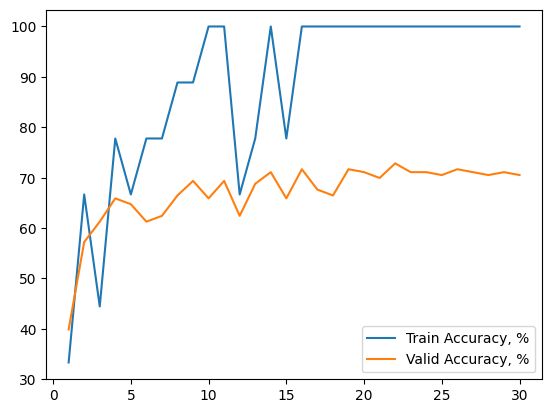

In [ ]:
plt.plot(x, train_accuracy_epoch_history, label="Train Accuracy, %")
plt.plot(x, valid_accuracy_epoch_history, label="Valid Accuracy, %")
plt.legend()

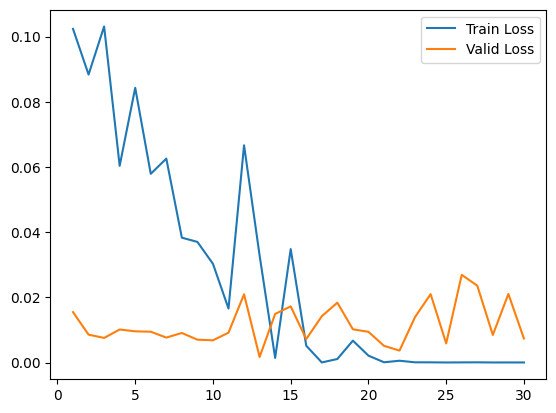

In [ ]:
plt.plot(x, train_loss_epoch_history, label="Train Loss")
plt.plot(x, valid_loss_epoch_history, label="Valid Loss")
plt.legend()

На основании графиков валидационной выборки видно, что после 15 эпохи улучшения предсказательной способности модели почти не происходит.

# Проверка точности на тестовых данных

Загрузим модель, которая дала наилучший результат на валидационных данных и проверим результат на тестовых данных. Точность предсказания языка 72%

In [ ]:
device = torch.device('cpu')
model = CNNModel()
model.load_state_dict(torch.load("models\lid\CNNModel-date(12-04-2023T19-16-00)-accuracy(72.83).pth", map_location=device))


correct_test, total_test, error_test = 0, 0, 0
for i, (images_test, labels_test) in enumerate(test_loader):
    outputs_test = model(images_test)
    error_test = loss(outputs_test, labels_test)
    _, predicted_test = torch.max(outputs_test.data, 1)
    total_test += labels_test.size(0)
    correct_test += (predicted_test == labels_test).sum().item()
    error_test += error_test
    
test_accuracy = (correct_test / total_test) * 100
print(test_accuracy)

72.25433526011561
